In [15]:
# from svg.path import Path, Line, Arc, CubicBezier, QuadraticBezier, Close, parse_path

import svg.path as spath
import numpy as np
import typing as tp
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from pynest.utils import create_rectangle, convex_hull_polygon

In [16]:
class ViewBox:

    def __init__(self, viewbox:str):
        viewbox_parts = viewbox.split(" ")
        viewbox_parts = [float(p) for p in viewbox_parts]
        self.xmin = viewbox_parts[0]
        self.ymin = viewbox_parts[1]
        self.width = viewbox_parts[2]
        self.height = viewbox_parts[3]


In [28]:
import numpy as np
import matplotlib.pyplot as plt

class Segment:
    """This class represents a line segment, represented
    by two points (x0, y0) and (x1, y1) on a plane.
    """
    def __init__(self, x0:float, y0:float, x1:float, y1:float):
        self.x0 = x0
        self.y0 = y0
        self.x1 = x1
        self.y1 = y1

    def __repr__(self) -> str:
        return f"Segment(({self.x0}, {self.y0}) -> ({self.x1}, {self.y1}))"
    
    @property
    def start(self):
        return (self.x0, self.y0,)

    @property
    def end(self):
        return (self.x1, self.y1, )

    def x_angle(self) -> float:
        """Finds the angle between the current segment
        and the x-axis.

        Returns:
            float: The angle
        """
        deltaX = self.x1 - self.x0
        deltaY = self.y1 - self.y0

        return np.arctan(deltaY/deltaX)

    def rotate(self,theta:float, center =(0,0,)):
        """Rotate the current segment by an angle
        theta considering the given center.

        Args:
            theta (float): The angle to rotate the segment
            center (tuple, optional): The center to rotate around. Defaults to (0,0,).

        """
        P = np.array([[self.x0, self.x1], 
                      [self.y0, self.y1]])
        C = np.array([[center[0], center[0]], 
                      [center[1], center[1]]])
        R = np.array([[np.cos(theta), -np.sin(theta)], 
                      [np.sin(theta), np.cos(theta)]])

        P = np.matmul(R, P - C) + C

        return Segment(P[0,0], P[1,0], P[0,1], P[1,1])

    def plot(self):
        points = np.array([self.start, self.end])
        plt.plot(points[:,0], points[:,1], 'k-', lw=1)

    def translate(self, x_dist:float, y_dist:float) -> None:
        """Translates a segment to a given x and y distance.
        """
        self.x0 += x_dist
        self.y0 += y_dist
        self.x1 += x_dist
        self.y1 += y_dist

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import typing as tp

class Polygon:
    
    def __init__(self):
        self.segments = []

    def add_segment(self, segment:Segment):
        self.segments.append(segment)

    
    def to_points(self) -> tp.List[tp.Tuple[float, float]]:
        points = []
        for segment in self.segments:
            points.append(segment.start())
            points.append(segment.end())

        return points

    def plot(self) -> None:
        for segment in self.segments:
            plt.plot(np.array([segment.x0, segment.x1]), np.array([segment.y0, segment.y1]), 'k-')

    def centroid(self) -> tp.Tuple[float, float]:
        points = np.array(self.to_points())
        x_center = np.mean(points[:, 0])
        y_center = np.mean(points[:, 1])
        
        return (x_center, y_center,)

    def rotate(self, theta, center: tp.Tuple[float, float] = None, inplace=False):

        if center is None:
            center = self.centroid()
            
        points = np.array(self.to_points())

        P = np.array([points[:, 0], points[:, 1]])
        C = np.array([[center[0] for _ in range(0, P.shape[1])],
                      [center[1] for _ in range(0, P.shape[1])]])
        R = np.array([[np.cos(theta), -np.sin(theta)], 
                      [np.sin(theta), np.cos(theta)]])

        P = np.matmul(R, P - C) + C 

        if inplace:
            pol = self
            self.segments = []
        else:
            pol = Polygon()
            
        x0 = P[0,0]
        y0 = P[1,0]

        for i in range(1, P.shape[1]):
            x1 = P[0, i]
            y1 = P[1, i]
            pol.add_segment(Segment(x0, y0, x1, y1))

            x0 = x1
            y0 = y1

        return pol

In [33]:

import svg.path as spath
import typing as tp

class Piece(Polygon):
    
    def __init__(self, name:str = ""):
        super().__init__()
        self.name=name
        self.segments: tp.List[Segment] = []

    def _get_scale(self, width:float, viewbox:ViewBox):
        scale_width = viewbox.width - viewbox.xmin
        return width/scale_width

    def _apply_transform(self, segment:Segment, transform:str) -> Segment:
        if transform is None:
            return segment

        if transform.startswith('translate'):
            transform = transform.replace("translate", "")\
                                .replace("(", "")\
                                .replace(")", "")
            parts = transform.split(',')
            x_dist = float(parts[0])
            y_dist = float(parts[1])
            segment.translate(x_dist, y_dist)
        
        if transform.startswith("rotate"):
            transform = transform.replace("rotate", "")\
                                .replace("(", "")\
                                .replace(")", "")
            parts = transform.split(",")
            theta = float(parts[0])
            xc = float(parts[1])
            yc = float(parts[2])
            segment.rotate(theta, (xc, yc,))

        return segment

    def add_segments_from_path(self, d:str, width: float, viewbox:ViewBox, transform:str = None):
        # Convert to path object
        path = spath.parse_path(d)
        segments = path._segments
        n_segments = len(segments)

        scale = self._get_scale(width, viewbox)

        # Iterate in path and map segments
        for i in range(1, n_segments):
            segment = segments[i]

            start = segment.start
            end = segment.end

            x0 = start.real 
            y0 = start.imag 
            x1 = end.real 
            y1 = end.imag

            segment = Segment(x0,y0,x1,y1)
            segment = self._apply_transform(segment, transform)
            
            segment.x0 *= scale
            segment.x1 *= scale
            segment.y0 *= scale
            segment.y1 *= scale

            self.segments.append(segment)


In [34]:

import numpy as np
from pynest.utils import convex_hull_polygon, create_rectangle
import typing as tp

class BoundingRect:
    
    def __init__(self, piece:Piece, shield:int = 2.5):
        self.piece: Piece = piece
        self.shield = shield
        self.x = None
        self.y = None
        self.width = None
        self.height = None

        self._set_min_bounding_rect()

    def _add_shield(self):
        self.width += 2 * self.shield
        self.height += 2 * self.shield
        self.piece.translate(self.shield, self.shield)

    def _set_min_bounding_rect(self):
        points = np.array(self.piece.to_points())
        convex_hull = convex_hull_polygon(points)

        min_area = np.Inf
        # Rotate the convex hull such that the current
        # segment is parallel to the x-axis.
        for segment in convex_hull.segments:
            theta = segment.x_angle()

            convex_hull_rotated = convex_hull.rotate(-theta, (0,0,))
            convex_hull_points = np.array(convex_hull_rotated.to_points())

            # Calculate bouding rectangle
            xs = convex_hull_points[:, 0]
            ys = convex_hull_points[:, 1]

            xmin = np.min(xs)
            xmax = np.max(xs)
            ymin = np.min(ys)
            ymax = np.max(ys)

            width = xmax - xmin
            height = ymax - ymin
            area = width * height

            if area < min_area:
                self.theta = theta
                self.x = xmin
                self.y = ymin
                self.width = width
                self.height = height
                # self.bounding_rect = rect
                # min_area = area

        self.piece.rotate(-self.theta, (0,0,), inplace=True)

        self._add_shield()
        self._translate_to_origin()

    def _translate_to_origin(self):
        self.piece.translate(-self.x, -self.y)
        self.x = 0.
        self.y = 0.

    def rotate(self, theta:float, center:tp.Tuple[float, float] = None):
        self.piece.rotate(theta, center, inplace=True)
        # self.bounding_rect = self.bounding_rect.rotate(theta, center)
        self.theta = self.theta + theta
        aux = self.width
        self.width = self.height
        self.height = aux

        return self

    def plot(self):
        x0 = self.x
        y0 = self.y
        x1 = self.x + self.width
        y1 = self.y + self.height
        
        rect = create_rectangle(x0, x1, y0, y1)
        rect.plot()

In [35]:
# piece = Piece()
# d = "m 863.75543,2856.5442 36.58061,-1.041 54.36118,-11.6531 34.2418,-13.422 -28.9434,-70.7006 -32.24996,4.8273 -27.98758,16.8396 -28.56594,11.3964 -16.92007,-24.5366 -40.93943,64.5001 z"
# translate = '0,-2404.804'
# rotate = '90,2458.5677,-419.95369'
# piece.add_segments_from_path(d, width, viewbox, rotate=None, translate=None)

# piece.plot()

In [36]:
viewbox = ViewBox("0 0 3162.3857 1629.1533")
width=836.71454

In [40]:
piece = Piece()
d="m 453.52874,2878.4034 -26.29384,-14.9351 -44.19787,0.7197 -42.56825,-11.9128 -23.31882,19.2525 -8.54157,-18.4569"
piece.add_segments_from_path(d, width, viewbox, transform="translate(0,-2404.804)")

d = "m 343.57926,426.41695 -34.97087,21.8499 -12.87935,17.1653 21.42093,1.2916 20.44505,7.6263 6.49176,-5.3597 -3.61799,-21.5191 5.41398,21.1388 21.5545,6.0321 15.59977,-15.2581 11.21681,18.7175 22.37968,-0.3644 10.60138,-19.0728 0.15345,21.8205 7.31993,4.1578 18.82046,-11.0432 18.32035,-8.8306 -37.33799,-17.5002 -47.24591,-2.6636 z"
piece.add_segments_from_path(d, width, viewbox)


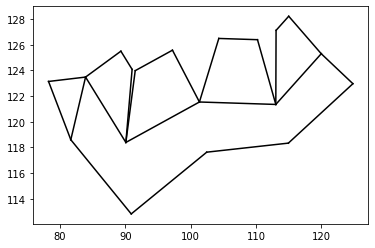

In [41]:
piece.plot()

In [20]:
# br.plot()
br = BoundingRect(piece)
# br = br.rotate(np.pi/2)

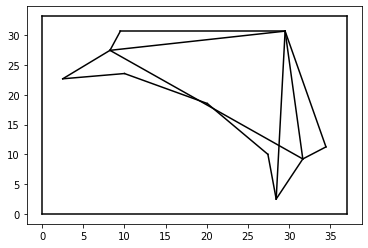

In [21]:
br.plot()
br.piece.plot()

In [ ]:
piece.plot()

In [ ]:
br = BoundingRect(piece)
br.set_min_bounding_rect(rotate_piece=True)
br.piece.plot()
br.bounding_rect.plot()

In [ ]:
piece = Piece()
d = "m 653.96365,44.29956 -4.46289,0.39063 -4.32618,1.16016 -4.06054,1.89257 -3.66992,2.57032 -3.16797,3.16601 -2.57032,3.66992 -1.89257,4.06055 -1.16016,4.328131 -0.39062,4.462889 0.39062,4.462891 1.16016,4.326169 1.89257,4.06055 2.57032,3.669919 3.16797,3.16797 3.66992,2.57031 4.06054,1.89258 4.32618,1.16015 4.46289,0.39063 4.46289,-0.39063 4.32812,-1.16015 4.0586,-1.89258 3.66992,-2.57031 3.16797,-3.16797 2.57031,-3.669919 1.89258,-4.06055 1.16015,-4.326169 0.39063,-4.462891 6.54297,-1.89258 h 7.28125 l 6.54101,1.89258 0.39063,4.462891 1.16015,4.326169 1.89258,4.06055 2.57031,3.669919 3.16797,3.16797 3.66993,2.57031 4.06054,1.89258 4.32617,1.16015 4.46289,0.39063 4.4629,-0.39063 4.32812,-1.16015 4.06055,-1.89258 3.66992,-2.57031 3.16601,-3.16797 2.57032,-3.669919 1.89453,-4.06055 1.1582,-4.326169 0.39063,-4.462891 -0.39063,-4.462889 -1.1582,-4.328131 -1.89453,-4.06055 -2.57032,-3.66992 -3.16601,-3.16601 -3.66992,-2.57032 -4.06055,-1.89257 -4.32812,-1.16016 -4.4629,-0.39063 -4.46289,0.39063 -4.32617,1.16016 -4.06054,1.89257 -3.66993,2.57032 -3.16797,3.16601 -2.57031,3.66992 -1.89258,4.06055 -1.16015,4.328131 -6.5332,-1.933601 h -8.08008 l -6.53321,1.933601 -1.16015,-4.328131 -1.89258,-4.06055 -2.57031,-3.66992 -3.16797,-3.16601 -3.66992,-2.57032 -4.0586,-1.89257 -4.32812,-1.16016 z m 0,4.88282 3.61523,0.3164 3.50586,0.93946 3.28711,1.5332 2.97266,2.08203 2.5664,2.56641 2.08203,2.9707 1.53321,3.28906 0.93945,3.50586 0.31641,3.61524 -0.31641,3.61523 -0.93945,3.50391 -1.53321,3.28906 -2.08203,2.97266 -2.5664,2.5664 -2.97266,2.080079 -3.28711,1.53516 -3.50586,0.9375 -3.61523,0.3164 -3.61524,-0.3164 -3.5039,-0.9375 -3.28907,-1.53516 -2.97265,-2.080079 -2.56641,-2.5664 -2.08203,-2.97266 -1.5332,-3.28906 -0.93946,-3.50391 -0.3164,-3.61523 0.3164,-3.61524 0.93946,-3.50586 1.5332,-3.28906 2.08203,-2.9707 2.56641,-2.56641 2.97265,-2.08203 3.28907,-1.5332 3.5039,-0.93946 z m 71.76757,0 3.61524,0.3164 3.50586,0.93946 3.28906,1.5332 2.9707,2.08203 2.56641,2.56641 2.08203,2.9707 1.5332,3.28906 0.93946,3.50586 0.3164,3.61524 -0.3164,3.61523 -0.93946,3.50391 -1.5332,3.28906 -2.08203,2.97266 -2.56641,2.5664 -2.9707,2.080079 -3.28906,1.53516 -3.50586,0.9375 -3.61524,0.3164 -3.61523,-0.3164 -3.50391,-0.9375 -3.28906,-1.53516 -2.97265,-2.080079 -2.56641,-2.5664 -2.08008,-2.97266 -1.53516,-3.28906 -0.9375,-3.50391 -0.3164,-3.61523 0.3164,-3.61524 0.9375,-3.50586 1.53516,-3.28906 2.08008,-2.9707 2.56641,-2.56641 2.97265,-2.08203 3.28906,-1.5332 3.50391,-0.93946 z"
piece.add_segments_from_path(d, width, viewbox)

convex_hull = convex_hull_polygon(np.array(piece.to_points()))

convex_hull.plot()
piece.plot()

In [ ]:
br = BoundingRect(piece)
br.set_min_bounding_rect(rotate_piece=True)
br.piece.plot()
br.bounding_rect.plot()

In [ ]:
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt

def convex_hull_polygon(points):
    hull = ConvexHull(points)
    chull = Polygon()

    for simplex in hull.simplices:
        x = points[simplex, 0]
        y = points[simplex, 1]

        # print(p0, p1)
        s = Segment(x[0], y[0], x[1], y[1])
        chull.add_segment(s)

    return chull

def create_rectangle(xmin, xmax, ymin, ymax):
    s1 = Segment(xmin, ymin, xmin, ymax)
    s2 = Segment(xmin, ymax, xmax, ymax)
    s3 = Segment(xmax, ymax, xmax, ymin)
    s4 = Segment(xmax, ymin, xmin, ymin)

    ret = Polygon()
    ret.add_segment(s1)
    ret.add_segment(s2)
    ret.add_segment(s3)
    ret.add_segment(s4)

    return ret


points = np.array(piece.to_points())
chull = convex_hull_polygon(points)

# plt.plot(points[:,0], points[:,1], 'o-')


min_ret = {
    'area': np.Inf,
    'theta': None,
    'ret': None,
    'convex_hull': None
}



for segment in chull.segments:
    # segment = chull.segments[2]
    theta = segment.x_angle()

    chull_rotated = chull.rotate(-theta, (0,0,))
    chull_points = np.array(chull_rotated.to_points())

    xs = chull_points[:, 0]
    ys = chull_points[:, 1]

    xmin = np.min(xs)
    xmax = np.max(xs)
    ymin = np.min(ys)
    ymax = np.max(ys)

    ret_area = (ymax - ymin) * (xmax - xmin)
    ret = create_rectangle(xmin, xmax, ymin, ymax)

    # chull_rotated.plot()
    # ret.plot()
    # piece.rotate(-0, (0,0,)).plot()

    if ret_area < min_ret['area']:
        min_ret['theta'] = theta
        min_ret['ret'] = ret
        min_ret['area'] = ret_area
        min_ret['convex_hull'] = chull_rotated

piece.rotate(-min_ret['theta'], (0,0,)).plot()
min_ret['ret'].plot()


# # Rotate to be paralle to x axis
# deltaX = p1[0] - p0[0]
# deltaY = p1[1] - p0[1]
# theta = np.arctan(deltaY/deltaX)



# plt.plot(points[simplex, 0], points[simplex, 1], 'r-')
# chull.plot()

